In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
from IPython.core.debugger import set_trace

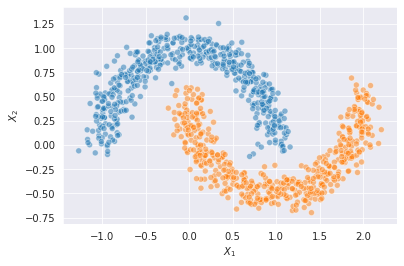

In [2]:
sns.set_style("darkgrid")
 
n_samples = 1000
n_noisy_dimensions = 1000

X, y = datasets.make_moons(n_samples=n_samples, noise=0.1)
X = (X).astype(np.float32)

# Scatter plot, dots colored by class value
df = pd.DataFrame(data = {"x": X[:,0], "y": X[:,1], "category": y})
sns.scatterplot(
    x="x",
    y="y",
    data=df,
    hue="category",
    legend=False,
    alpha=0.5
)

plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.savefig("two_moons.png")

In [3]:
from models import MLP
import torch
from torch import optim
from torch.nn import MSELoss
from torch.nn import CrossEntropyLoss

torch.manual_seed(42)

In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from data import BasicDataset, generate_two_moons_data

learning_rate = 5e-4
prior_learning_rate = 5e-4

patience = 100

train_loader, valid_loader, test_loader = generate_two_moons_data(n_noisy_dimensions=1000)

In [5]:
D_in = train_loader.dataset.X.shape[1]
H1 = D_in // 4
H2 = H1 // 2
D_out = 2

f1 = MLP(D_in = D_in, H1 = H1, H2 = H2, D_out = D_out, dropout = 0.0).cuda()
f1_optimizer = optim.Adam(f1.parameters(), lr=learning_rate)

Running this next cell demonstrates that a basic MLP only learns noise in the data, and not any meaningful features.

In [6]:
from utils import EarlyStopping

criterion = CrossEntropyLoss()

mlp_accuracies = []
def train(model):
    
    print("Beginning model training at {}".format(datetime.datetime.now()))
    
    early_stopping = EarlyStopping(patience=patience, minimize=False)
    epoch = 0
    
    while True:
        start_time = time.time()
        
        model.train()
        for X_batch, y_batch in train_loader:
            y_batch = y_batch.squeeze()
            X_batch = torch.FloatTensor(X_batch).cuda()
            y_batch = torch.LongTensor(y_batch).cuda()
            
            f1_optimizer.zero_grad()
            
            output = model(X_batch)
            loss_train = criterion(output, y_batch)
            loss_train.backward()
            f1_optimizer.step()
            
        model.eval()
        for X_batch, y_batch in valid_loader:
            y_batch = y_batch.squeeze()
            X_batch = torch.FloatTensor(X_batch).cuda()
            y_batch = torch.LongTensor(y_batch).cuda()
            
            output = model(X_batch)
            loss_valid = criterion(output, y_batch).item()
            class_probabilities = torch.nn.Softmax()(output)
            predicted_classes = torch.argmax(class_probabilities, dim=1)
            correct_predictions = (predicted_classes == y_batch).float()
            accuracy = (correct_predictions.sum()/correct_predictions.shape[0]).item()
            #set_trace()
            end_time = time.time()
            epoch_time = end_time - start_time
            mlp_accuracies.append(accuracy)
            
        if epoch % 10 == 0:
            print("Epoch {} completed in {} secs with validation loss, accuracy {:.4f},{:.4f}".format(epoch, epoch_time, loss_valid, accuracy))
           
        epoch += 1
        # early_stopping needs the validation loss to check if it has decreased, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(accuracy, model)
        
        if early_stopping.early_stop:
            print("Early stopping on epoch {}".format(epoch))
            break
            
    model.load_state_dict(torch.load('checkpoint.pt'))
    for X_batch, y_batch in test_loader:
        y_batch = y_batch.squeeze()
        X_batch = torch.FloatTensor(X_batch).cuda()
        y_batch = torch.LongTensor(y_batch).cuda()

        output = model(X_batch)
        loss_valid = criterion(output, y_batch).item()
        class_probabilities = torch.nn.Softmax()(output)
        predicted_classes = torch.argmax(class_probabilities, dim=1)
        correct_predictions = (predicted_classes == y_batch).float()
        accuracy = (correct_predictions.sum()/correct_predictions.shape[0]).item()
        end_time = time.time()
        epoch_time = end_time - start_time
    return accuracy

In [7]:
train(f1)

Beginning model training at 2019-11-28 13:19:18.471251
Epoch 0 completed in 0.10626554489135742 secs with validation loss, accuracy 0.6902,0.5150
Validation loss decreased (inf --> 0.515000).  Saving model ...
Validation loss decreased (0.515000 --> 0.530000).  Saving model ...


/homes/gws/ewein/.local/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Validation loss decreased (0.530000 --> 0.540000).  Saving model ...
Validation loss decreased (0.540000 --> 0.555000).  Saving model ...
Epoch 10 completed in 0.024827957153320312 secs with validation loss, accuracy 0.8918,0.5350
Epoch 20 completed in 0.025948762893676758 secs with validation loss, accuracy 0.9478,0.5325
Epoch 30 completed in 0.02400827407836914 secs with validation loss, accuracy 0.9838,0.5375
Epoch 40 completed in 0.022640705108642578 secs with validation loss, accuracy 1.0127,0.5375
Epoch 50 completed in 0.026200294494628906 secs with validation loss, accuracy 1.0367,0.5375
Epoch 60 completed in 0.02353978157043457 secs with validation loss, accuracy 1.0573,0.5350
Epoch 70 completed in 0.021185874938964844 secs with validation loss, accuracy 1.0753,0.5325
Epoch 80 completed in 0.02395772933959961 secs with validation loss, accuracy 1.0913,0.5325
Epoch 90 completed in 0.023453235626220703 secs with validation loss, accuracy 1.1058,0.5325
Epoch 100 completed in 0.025

/homes/gws/ewein/.local/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.492499977350235

In [9]:
import egexplainer
import importlib

importlib.reload(egexplainer)

APExp = egexplainer.VariableBatchExplainer(train_loader.dataset)

In [12]:
from models import ShallowMLP, LinearModel

f1 = MLP(D_in = D_in, H1 = H1, H2 = H2, D_out = D_out, dropout = 0.0).cuda()
f1_optimizer = optim.Adam(f1.parameters(), lr=learning_rate)

std = train_loader.dataset.X.std(axis=0).reshape(-1,1)
mean = train_loader.dataset.X.mean(axis=0).reshape(-1,1)
prior_info = np.concatenate((std, mean), axis=1)
prior_info = torch.FloatTensor(prior_info).cuda()

f2 = LinearModel(D_in=prior_info.shape[1], D_out=1).cuda()
f2_optimizer = optim.Adam(f2.parameters(), lr=prior_learning_rate)

In [13]:
prior_accuracies = []
def train_with_learned_prior(f1, f2):
     
    classification_criterion = CrossEntropyLoss()
    
    print("Beginning model training at {}".format(datetime.datetime.now()))
    
    early_stopping = EarlyStopping(patience=patience, minimize=False)
    epoch = 0
    
    while True:
        start_time = time.time()
        f1.train()
        f2.train()
        
        for X_batch, y_batch in train_loader:
            y_batch = y_batch.squeeze()
            X_batch = torch.FloatTensor(X_batch).cuda()
            y_batch = torch.LongTensor(y_batch).cuda()
        
            f1_optimizer.zero_grad()
            f2_optimizer.zero_grad()
            
            output = f1(X_batch)
            classification_loss = classification_criterion(output, y_batch)
            
            eg = APExp.shap_values(f1, X_batch, sparse_labels=y_batch)
            prior_differences = f2(prior_info).squeeze()
            
            # This works pretty well! Why?
            prior_loss = (prior_differences - eg).abs().mean()
            train_loss = classification_loss + prior_loss
            
            train_loss.backward()
            f1_optimizer.step()
            f2_optimizer.step()
            
        
        f1.eval()
        for X_batch, y_batch in valid_loader:
            y_batch = y_batch.squeeze()
            X_batch = torch.FloatTensor(X_batch).cuda()
            y_batch = torch.LongTensor(y_batch).cuda()
            output = f1(X_batch)
            loss_valid = classification_criterion(output, y_batch)
            
            class_probabilities = torch.nn.Softmax()(output)
            predicted_classes = torch.argmax(class_probabilities, dim=1)
            correct_predictions = (predicted_classes == y_batch).float()
            accuracy = (correct_predictions.sum()/correct_predictions.shape[0]).item()
            end_time = time.time()
            epoch_time = end_time - start_time
            prior_accuracies.append(accuracy)
            
        if epoch % 10 == 0:
            print("Epoch {} completed in {} secs with test loss, accuracy {:.4f},{:.4f}".format(epoch, epoch_time, loss_valid, accuracy))
        
        # early_stopping needs the validation loss to check if it has decreased, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(accuracy, [f1, f2])
        epoch += 1
        if early_stopping.early_stop:
            print("Early stopping on epoch {}".format(epoch))
            break
            
    f1.load_state_dict(torch.load('checkpoint_0.pt'))
    f2.load_state_dict(torch.load('checkpoint_1.pt'))
        
    for X_batch, y_batch in test_loader:
        y_batch = y_batch.squeeze()
        X_batch = torch.FloatTensor(X_batch).cuda()
        y_batch = torch.LongTensor(y_batch).cuda()

        output = f1(X_batch)
        loss_valid = criterion(output, y_batch).item()
        class_probabilities = torch.nn.Softmax()(output)
        predicted_classes = torch.argmax(class_probabilities, dim=1)
        correct_predictions = (predicted_classes == y_batch).float()
        accuracy = (correct_predictions.sum()/correct_predictions.shape[0]).item()
        #set_trace()
        end_time = time.time()
        epoch_time = end_time - start_time
    return accuracy

In [14]:
train_with_learned_prior(f1, f2)

Beginning model training at 2019-11-28 13:20:27.079170
Epoch 0 completed in 0.06131291389465332 secs with test loss, accuracy 0.6919,0.5275
Validation loss decreased (inf --> 0.527500).  Saving model ...
Validation loss decreased (0.527500 --> 0.540000).  Saving model ...


/homes/gws/ewein/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Validation loss decreased (0.540000 --> 0.540000).  Saving model ...
Validation loss decreased (0.540000 --> 0.540000).  Saving model ...
Epoch 10 completed in 0.06396746635437012 secs with test loss, accuracy 0.8690,0.5425
Validation loss decreased (0.540000 --> 0.542500).  Saving model ...
Validation loss decreased (0.542500 --> 0.545000).  Saving model ...
Validation loss decreased (0.545000 --> 0.545000).  Saving model ...
Validation loss decreased (0.545000 --> 0.545000).  Saving model ...
Validation loss decreased (0.545000 --> 0.547500).  Saving model ...
Validation loss decreased (0.547500 --> 0.547500).  Saving model ...
Validation loss decreased (0.547500 --> 0.550000).  Saving model ...
Validation loss decreased (0.550000 --> 0.555000).  Saving model ...
Epoch 20 completed in 0.0518801212310791 secs with test loss, accuracy 0.7752,0.5550
Validation loss decreased (0.555000 --> 0.555000).  Saving model ...
Validation loss decreased (0.555000 --> 0.562500).  Saving model ...
V

/homes/gws/ewein/.local/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.7599999904632568

In [ ]:
sns.set_style("darkgrid")
plt.plot(mlp_accuracies, label="MLP")
plt.plot(prior_accuracies, label="MLP w/ Learned Prior")
plt.xlabel("Epoch")
plt.ylabel("Validation Set Accuracy")
plt.legend()
plt.show()

In [ ]:
from sklearn import linear_model

clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_train, y_train)

predictions = clf.predict(X_train)
predictions = [0 if prediction < 0.5 else 1 for prediction in predictions]
results = predictions == y_train
results.sum()/results.shape[0]

In [ ]:
from data import BasicDataset

prior_data = BasicDataset(X = prior_info, y = np.zeros(prior_info.shape[0]))

meta_APExp = egexplainer.VariableBatchExplainer(prior_data)

In [ ]:
predicted_attributions = f2(prior_info).squeeze().abs().cpu().detach().numpy()
meta_eg = meta_APExp.shap_values(f2, prior_info).abs().cpu().detach().numpy()

In [ ]:
real_feature_names = ["$X_1$", "$X_2$"]
noisy_feature_names = ["Noise Feature {}".format(str(i)) for i in range(n_noisy_dimensions)]
all_feature_names = real_feature_names + noisy_feature_names

meta_eg = meta_eg/meta_eg.sum(axis=1, keepdims=True)
meta_eg = (meta_eg.T * predicted_attributions).T
df = pd.DataFrame(data={
    "stdev": meta_eg[:,0],
    "mean": meta_eg[:,1],
    "total_attribution": meta_eg.sum(axis=1),
    "y":all_feature_names
})

In [ ]:
sns.set_style("darkgrid")
sns.set_context({"figure.figsize": (24, 10)})

#Plot 1 - background - "total" (top) series
main_plot = sns.barplot(
    x = "stdev",
    y = "y",
    data=df.nlargest(10, "total_attribution"),
    color = "red")

bottom_plot = sns.barplot(x = "mean", y = "y", data=df.nlargest(10, "total_attribution"), color = "#0000A3")

topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')
l = plt.legend(
    [bottombar, topbar],
    ['Feature Mean', 'Feature Stdev'],
    ncol = 2,
    prop={'size':18}
)
l.draw_frame(False)

sns.despine(left=True)
bottom_plot.set_ylabel("")
bottom_plot.set_xlabel("Predicted Feature Importance")

#Set fonts to consistent 16pt size
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(18)

fig = plt.gcf()
fig.set_size_inches(15.5, 10.5)
    
plt.tight_layout()